Alireza Safarkhani 97101983 / Shayan Ghaledar 97102271

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib
from random import shuffle
from skimage.io import imread
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier

در ابتدا داده های تصاویر را مشابه آزهای قبلی می خوانیم. در دو بلوک بعدی این کار هم برای خوشحال و هم متعجب انجام شده است

In [3]:
data_h = []
person_number = []
path =  r"C:\Users\MT\Downloads\Vision_Lab1_ShayanGhaledar_AlirezaSafarkhani\happy"
happy_counter = 0
for file in os.listdir(path):
    if file[-3:] in {'png'}:
        person_number.append(file[1:4])
        img = imread(path+'/'+file, as_gray=True)
        data_h.append(img)
        happy_counter = happy_counter + 1
        
height,width = np.shape(img)
happy_im_matrix = np.zeros((height*width,happy_counter))
for i in range(happy_counter):
    happy_im_matrix[:,i] = np.reshape(data_h[i],(height*width,))
    


In [4]:
data_s = []
person_number = []
path = r"C:\Users\MT\Downloads\Vision_Lab1_ShayanGhaledar_AlirezaSafarkhani\surprise"
surprise_counter = 0
for file in os.listdir(path):
    if file[-3:] in {'png'}:
        person_number.append(file[1:4])
        img = imread(path+'/'+file, as_gray=True)
        data_s.append(img)
        surprise_counter = surprise_counter + 1

height,width = np.shape(img)
surprise_im_matrix = np.zeros((height*width,surprise_counter))

for i in range(surprise_counter):
    surprise_im_matrix[:,i] = np.reshape(data_s[i],(height*width,))
    


در بلوک بعدی بعد از شافل کردن 50 تصویر به عنوان ترین و بقیه برای تست انتخاب می گردد.

In [10]:
happy_index = np.array(list(range(happy_counter)))
surprise_index = np.array(list(range(surprise_counter)))
shuffle(happy_index)
shuffle(surprise_index)


train_image = np.zeros((height*width,100))
ytrain = np.zeros((100,))
test_image = np.zeros((height*width,surprise_counter+happy_counter - 100))
ytest = np.zeros((surprise_counter+happy_counter - 100,))

train_image[:,0:50] =  happy_im_matrix[:,happy_index[0:50]]
train_image[:,50:100] =  surprise_im_matrix[:,surprise_index[0:50]]
ytrain[0:50] = 1
ytrain[50:100] = 0

test_image[:,0:happy_counter-50] = happy_im_matrix[:,happy_index[50:happy_counter]]
ytest[0:happy_counter-50]   = 1
test_image[:,happy_counter-50:surprise_counter+happy_counter - 100] = surprise_im_matrix[:,surprise_index[50:surprise_counter]]
ytest[happy_counter-50:surprise_counter+happy_counter - 100]   = 0

در ادامه الگوریتم پی سی ای را اعمال کرده و تعدادی تصویر چهره ویژه رسم شده است.

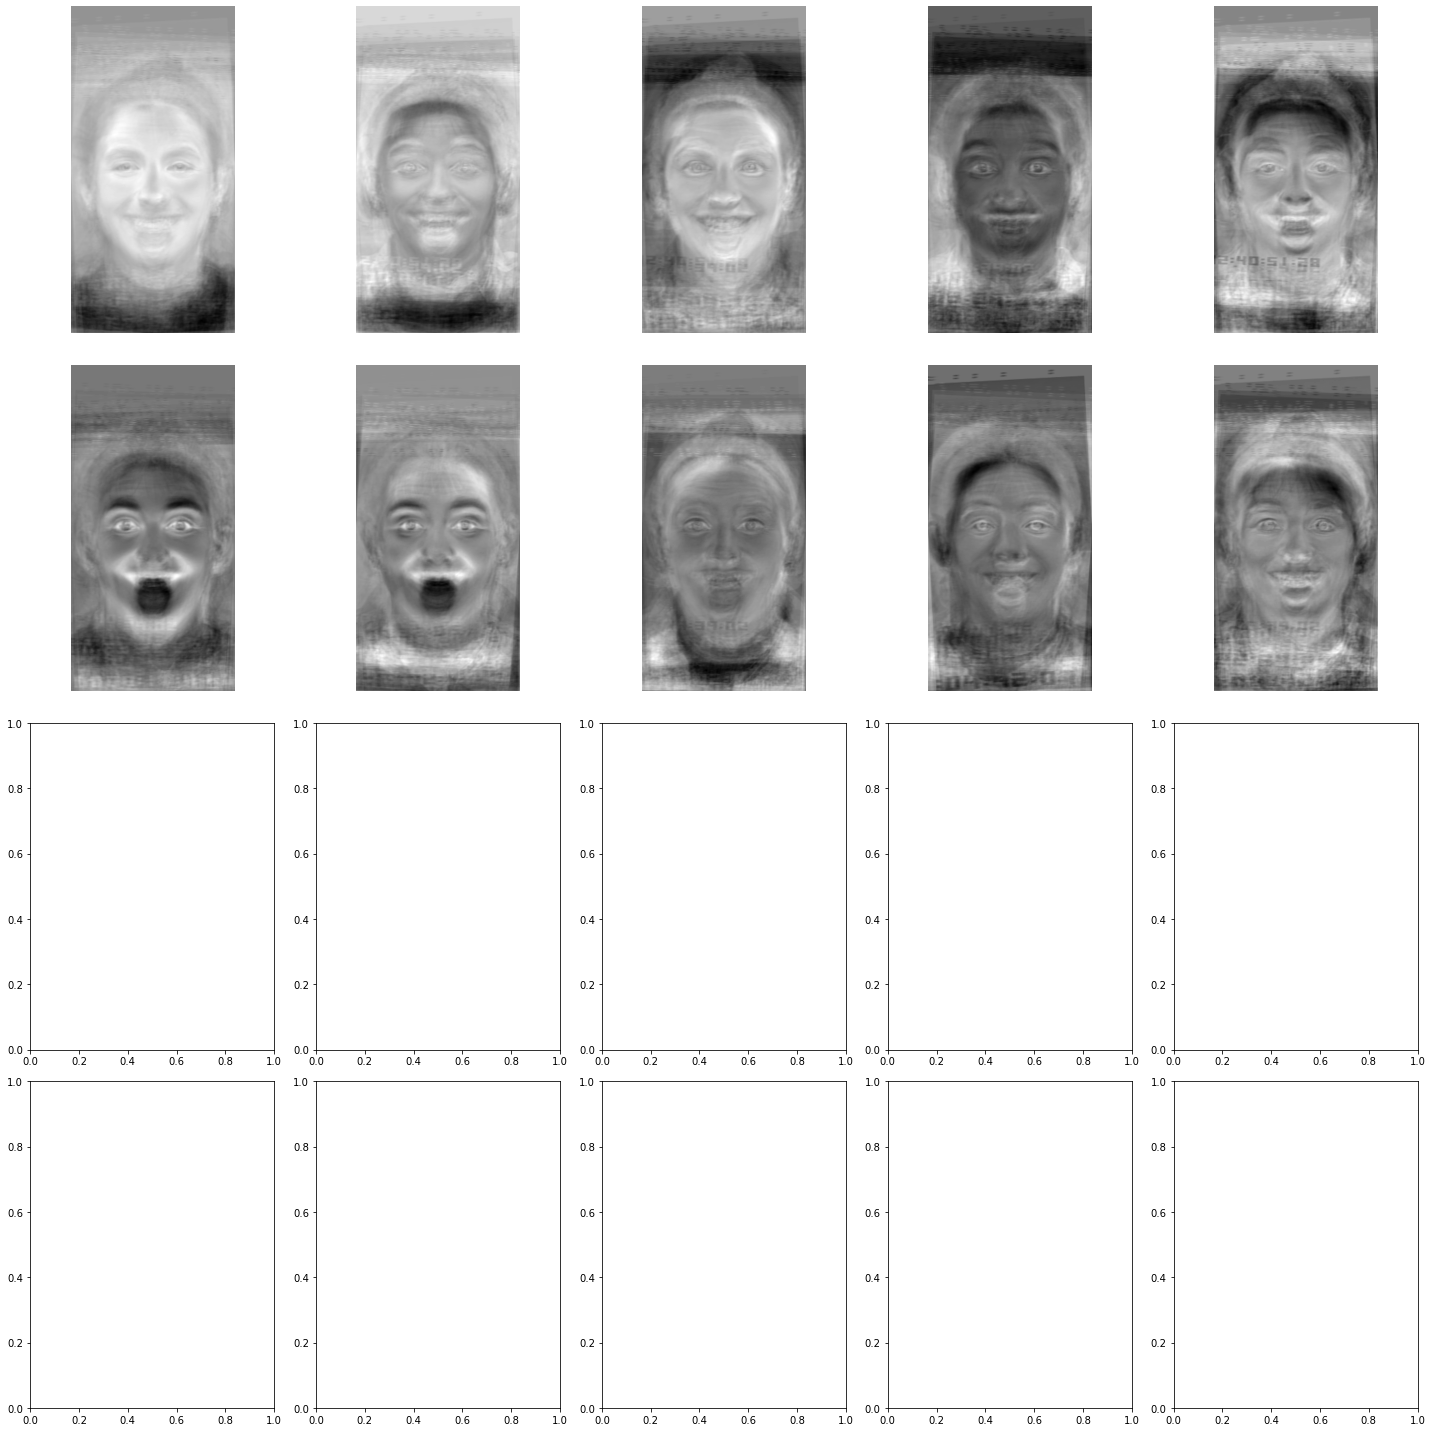

In [11]:
m = np.mean(train_image,1)
A = np.zeros(np.shape(train_image))
At = np.zeros(np.shape(test_image))

for i in range(train_image.shape[1]):
    A[:,i] = train_image[:,i] - m
for i in range(test_image.shape[1]):
    At[:,i] = test_image[:,i] - m
    
C_t = np.matmul(np.transpose(A),A)
eigenValues, eigenVectors = np.linalg.eig(C_t)

n =10   # the number of important eigen vectors
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
eigenVectors = eigenVectors[:,0:n]
eigenVectors = np.matmul(A,eigenVectors)
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
ax = axes.ravel()

for i in range(n):
    eigenVectors[:,i] = eigenVectors[:,i]/np.linalg.norm(eigenVectors[:,i])
    if i < 20:
        ax[i].imshow(np.reshape(eigenVectors[:,i],(height,width)), cmap=plt.cm.gray)
        ax[i].axis('off')
        
fig.tight_layout()
plt.show()


سپس در بلوک زیر ویژگی هایمان را از روی بردار ویژه های بخش قبل بدست آورده ایم.

In [12]:
pca_train_feature = np.matmul(np.transpose(eigenVectors),A)
pca_train_feature = pca_train_feature.T
pca_test_feature = np.matmul(np.transpose(eigenVectors),At)
pca_test_feature = pca_test_feature.T

در بخش بعدی الگوریتم ال دی ای را روی داده های ترین اعمال کرده و سپس روی تست پیش بینی انجام دادیم که مشاهده می شود دقت خوبی دارد. 

In [13]:
lda = LDA(n_components=1).fit(pca_train_feature, ytrain)
prediction_y = lda.predict(pca_test_feature)
print('train score with lda = ')
print(lda.score(pca_train_feature, ytrain))
print('test score with lda = ')
print(lda.score(pca_test_feature, ytest))

train score with lda = 
0.95
test score with lda = 
0.9178082191780822


دقت شود چون دو کلاس داریم بنابراین یک بردار ویژه فیشر به دست آمده است. حال می خواهیم آن را در فضای پیکسلی بازسازی کنیم.با ضرب کردن وزن های اسکیلینگ ال دی ای در بردارهای ویژه و جمع کردنشان تصویر بدست می اید

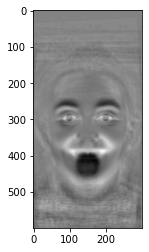

In [15]:
eigbase = lda.scalings_
tmp = np.zeros((height*width,))

for i in range(n):
    tmp = eigbase[i]*eigenVectors[:,i] + tmp
    
plt.imshow(tmp.reshape(height,-1),cmap='gray')

با دقت در تصویر بالا می بینیم که تغییرات عمدتا حول ابروها و دهان می باشد و این نواحی دقیقا ناحیه هایی اند که در حالات خوشحال و سورپرایز تفاوت قابل توجهی نسبت به هم پیدا می کنند. پس یعنی ویژگی های فیشر ما مناسب اند چراکه تفاوت بین کلاس ها را خوب هایلایت کرده اند.

در بلوک بعدی از روش کا ان ان برای طبقه بندی استفاده کرده تا مقایسه ای بین این روش و فیشر در حالت 10 چهره ویژه داشته باشیم.مشاهده می کنید که دقت روش ال دی ای از کا ان ان بهتر می باشد. 

In [311]:
knn = KNN(n_neighbors=1).fit(pca_train_feature, ytrain)
print("KNN with k = 1")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)
knn = KNN(n_neighbors=3).fit(pca_train_feature, ytrain)
print("KNN with k = 3")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)
knn = KNN(n_neighbors=5).fit(pca_train_feature, ytrain)
print("KNN with k = 5")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)


KNN with k = 1
0.5616438356164384
KNN with k = 3
0.684931506849315
KNN with k = 5
0.7534246575342466


در بلوک بعدی به جای 10 چهره ویژه از 20 چهره ویژه استفاده شد و مجددا ال دی ای و کا ان ان را اعمال کرده ایم. مشاهده می شود هم روش ال دی ای نتیجه اش بهبود یافت و هم کا ان ان به ازای کا های مختلف. ولی کماکان برتری روش ال دی ای را ملاحظه می کنید.

In [16]:
happy_index = np.array(list(range(happy_counter)))
surprise_index = np.array(list(range(surprise_counter)))
shuffle(happy_index)
shuffle(surprise_index)


train_image = np.zeros((height*width,100))
ytrain = np.zeros((100,))
test_image = np.zeros((height*width,surprise_counter+happy_counter - 100))
ytest = np.zeros((surprise_counter+happy_counter - 100,))

train_image[:,0:50] =  happy_im_matrix[:,happy_index[0:50]]
train_image[:,50:100] =  surprise_im_matrix[:,surprise_index[0:50]]
ytrain[0:50] = 1
ytrain[50:100] = 0

test_image[:,0:happy_counter-50] = happy_im_matrix[:,happy_index[50:happy_counter]]
ytest[0:happy_counter-50]   = 1
test_image[:,happy_counter-50:surprise_counter+happy_counter - 100] = surprise_im_matrix[:,surprise_index[50:surprise_counter]]
ytest[happy_counter-50:surprise_counter+happy_counter - 100]   = 0


m = np.mean(train_image,1)
A = np.zeros(np.shape(train_image))
for i in range(train_image.shape[1]):
    A[:,i] = train_image[:,i] - m
C_t = np.matmul(np.transpose(A),A)
eigenValues, eigenVectors = np.linalg.eig(C_t)

n = 20    # the number of important eigen vectors
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
eigenVectors = eigenVectors[:,0:n]
eigenVectors = np.matmul(A,eigenVectors)

for i in range(n):
    eigenVectors[:,i] = eigenVectors[:,i]/np.linalg.norm(eigenVectors[:,i])


pca_train_feature = np.matmul(np.transpose(eigenVectors),A)
pca_train_feature = pca_train_feature.T
pca_test_feature = np.matmul(np.transpose(eigenVectors),At)
pca_test_feature = pca_test_feature.T


lda = LDA(n_components=1).fit(pca_train_feature, ytrain)
prediction_y = lda.predict(pca_test_feature)
print('train score with lda = ')
print(lda.score(pca_train_feature, ytrain))
print('test score with lda = ')
print(lda.score(pca_test_feature, ytest))

knn = KNN(n_neighbors=1).fit(pca_train_feature, ytrain)
print("KNN = 1")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)
knn = KNN(n_neighbors=3).fit(pca_train_feature, ytrain)
print("KNN = 3")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)
knn = KNN(n_neighbors=5).fit(pca_train_feature, ytrain)
print("KNN = 5")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)


train score with lda = 
0.99
test score with lda = 
0.9863013698630136
KNN = 1
0.821917808219178
KNN = 3
0.7671232876712328
KNN = 5
0.7397260273972602


بلوک بعدی هم دقیقا مثل قبلی است با این تفاوت که از 30 بردار ویژه برتر پی سی ای استفاده کردیم. این بار دقت ال دی ای به 100 درصد می رسد و کا ان ان باز هم بهتر می شود و از ال دی ای ضعیف تر است.

In [17]:
happy_index = np.array(list(range(happy_counter)))
surprise_index = np.array(list(range(surprise_counter)))
shuffle(happy_index)
shuffle(surprise_index)


train_image = np.zeros((height*width,100))
ytrain = np.zeros((100,))
test_image = np.zeros((height*width,surprise_counter+happy_counter - 100))
ytest = np.zeros((surprise_counter+happy_counter - 100,))

train_image[:,0:50] =  happy_im_matrix[:,happy_index[0:50]]
train_image[:,50:100] =  surprise_im_matrix[:,surprise_index[0:50]]
ytrain[0:50] = 1
ytrain[50:100] = 0

test_image[:,0:happy_counter-50] = happy_im_matrix[:,happy_index[50:happy_counter]]
ytest[0:happy_counter-50]   = 1
test_image[:,happy_counter-50:surprise_counter+happy_counter - 100] = surprise_im_matrix[:,surprise_index[50:surprise_counter]]
ytest[happy_counter-50:surprise_counter+happy_counter - 100]   = 0


m = np.mean(train_image,1)
A = np.zeros(np.shape(train_image))
for i in range(train_image.shape[1]):
    A[:,i] = train_image[:,i] - m
C_t = np.matmul(np.transpose(A),A)
eigenValues, eigenVectors = np.linalg.eig(C_t)

n = 30    # the number of important eigen vectors
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
eigenVectors = eigenVectors[:,0:n]
eigenVectors = np.matmul(A,eigenVectors)

for i in range(n):
    eigenVectors[:,i] = eigenVectors[:,i]/np.linalg.norm(eigenVectors[:,i])


pca_train_feature = np.matmul(np.transpose(eigenVectors),A)
pca_train_feature = pca_train_feature.T
pca_test_feature = np.matmul(np.transpose(eigenVectors),At)
pca_test_feature = pca_test_feature.T


lda = LDA(n_components=1).fit(pca_train_feature, ytrain)
prediction_y = lda.predict(pca_test_feature)
print('train score with lda = ')
print(lda.score(pca_train_feature, ytrain))
print('test score with lda = ')
print(lda.score(pca_test_feature, ytest))

knn = KNN(n_neighbors=1).fit(pca_train_feature, ytrain)
print("KNN = 1")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)
knn = KNN(n_neighbors=3).fit(pca_train_feature, ytrain)
print("KNN = 3")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)
knn = KNN(n_neighbors=5).fit(pca_train_feature, ytrain)
print("KNN = 5")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)


train score with lda = 
1.0
test score with lda = 
1.0
KNN = 1
0.8904109589041096
KNN = 3
0.8493150684931506
KNN = 5
0.8356164383561644


در بلوک بعدی از 40 چهره ویژه برتر استفاده کردیم. ال دی ای کماکان دقت 100 درصدی دارد و کا ان ان به صورت کلی کمی بهتر شده است. به نظر می رسد افزایش بیشتر هم همین روند را نتیجه دهد. بنابراین برای 50 هم به عنوان اخرین مورد امتحان می کنیم.

In [18]:
happy_index = np.array(list(range(happy_counter)))
surprise_index = np.array(list(range(surprise_counter)))
shuffle(happy_index)
shuffle(surprise_index)


train_image = np.zeros((height*width,100))
ytrain = np.zeros((100,))
test_image = np.zeros((height*width,surprise_counter+happy_counter - 100))
ytest = np.zeros((surprise_counter+happy_counter - 100,))

train_image[:,0:50] =  happy_im_matrix[:,happy_index[0:50]]
train_image[:,50:100] =  surprise_im_matrix[:,surprise_index[0:50]]
ytrain[0:50] = 1
ytrain[50:100] = 0

test_image[:,0:happy_counter-50] = happy_im_matrix[:,happy_index[50:happy_counter]]
ytest[0:happy_counter-50]   = 1
test_image[:,happy_counter-50:surprise_counter+happy_counter - 100] = surprise_im_matrix[:,surprise_index[50:surprise_counter]]
ytest[happy_counter-50:surprise_counter+happy_counter - 100]   = 0


m = np.mean(train_image,1)
A = np.zeros(np.shape(train_image))
for i in range(train_image.shape[1]):
    A[:,i] = train_image[:,i] - m
C_t = np.matmul(np.transpose(A),A)
eigenValues, eigenVectors = np.linalg.eig(C_t)

n = 40    # the number of important eigen vectors
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
eigenVectors = eigenVectors[:,0:n]
eigenVectors = np.matmul(A,eigenVectors)

for i in range(n):
    eigenVectors[:,i] = eigenVectors[:,i]/np.linalg.norm(eigenVectors[:,i])


pca_train_feature = np.matmul(np.transpose(eigenVectors),A)
pca_train_feature = pca_train_feature.T
pca_test_feature = np.matmul(np.transpose(eigenVectors),At)
pca_test_feature = pca_test_feature.T


lda = LDA(n_components=1).fit(pca_train_feature, ytrain)
prediction_y = lda.predict(pca_test_feature)
print('train score with lda = ')
print(lda.score(pca_train_feature, ytrain))
print('test score with lda = ')
print(lda.score(pca_test_feature, ytest))

knn = KNN(n_neighbors=1).fit(pca_train_feature, ytrain)
print("KNN = 1")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)
knn = KNN(n_neighbors=3).fit(pca_train_feature, ytrain)
print("KNN = 3")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)
knn = KNN(n_neighbors=5).fit(pca_train_feature, ytrain)
print("KNN = 5")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)


train score with lda = 
1.0
test score with lda = 
1.0
KNN = 1
0.8356164383561644
KNN = 3
0.863013698630137
KNN = 5
0.863013698630137


در بلوک بعدی از 50 چهره ویژه استفاده کردیم و نهایتا کماکان ال دی ای دقت 100 درصدی دارد ولی کا ان ان شروع به افت کرد. در نهایت نتیجه می گیریم روش فیشر ال دی ای در اینجا گزینه بهتری نسبت به کا ان ان می باشد

In [19]:
happy_index = np.array(list(range(happy_counter)))
surprise_index = np.array(list(range(surprise_counter)))
shuffle(happy_index)
shuffle(surprise_index)


train_image = np.zeros((height*width,100))
ytrain = np.zeros((100,))
test_image = np.zeros((height*width,surprise_counter+happy_counter - 100))
ytest = np.zeros((surprise_counter+happy_counter - 100,))

train_image[:,0:50] =  happy_im_matrix[:,happy_index[0:50]]
train_image[:,50:100] =  surprise_im_matrix[:,surprise_index[0:50]]
ytrain[0:50] = 1
ytrain[50:100] = 0

test_image[:,0:happy_counter-50] = happy_im_matrix[:,happy_index[50:happy_counter]]
ytest[0:happy_counter-50]   = 1
test_image[:,happy_counter-50:surprise_counter+happy_counter - 100] = surprise_im_matrix[:,surprise_index[50:surprise_counter]]
ytest[happy_counter-50:surprise_counter+happy_counter - 100]   = 0


m = np.mean(train_image,1)
A = np.zeros(np.shape(train_image))
for i in range(train_image.shape[1]):
    A[:,i] = train_image[:,i] - m
C_t = np.matmul(np.transpose(A),A)
eigenValues, eigenVectors = np.linalg.eig(C_t)

n = 50    # the number of important eigen vectors
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
eigenVectors = eigenVectors[:,0:n]
eigenVectors = np.matmul(A,eigenVectors)

for i in range(n):
    eigenVectors[:,i] = eigenVectors[:,i]/np.linalg.norm(eigenVectors[:,i])


pca_train_feature = np.matmul(np.transpose(eigenVectors),A)
pca_train_feature = pca_train_feature.T
pca_test_feature = np.matmul(np.transpose(eigenVectors),At)
pca_test_feature = pca_test_feature.T


lda = LDA(n_components=1).fit(pca_train_feature, ytrain)
prediction_y = lda.predict(pca_test_feature)
print('train score with lda = ')
print(lda.score(pca_train_feature, ytrain))
print('test score with lda = ')
print(lda.score(pca_test_feature, ytest))

knn = KNN(n_neighbors=1).fit(pca_train_feature, ytrain)
print("KNN = 1")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)
knn = KNN(n_neighbors=3).fit(pca_train_feature, ytrain)
print("KNN = 3")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)
knn = KNN(n_neighbors=5).fit(pca_train_feature, ytrain)
print("KNN = 5")
print(knn.score(pca_test_feature, ytest))
prediction_y = knn.predict(pca_test_feature)

train score with lda = 
1.0
test score with lda = 
1.0
KNN = 1
0.8082191780821918
KNN = 3
0.7945205479452054
KNN = 5
0.821917808219178
